# Loading of the pickle files from "extractingfeatures.ipynb"
---

In this notebook, I will open the pickle files and create the images of the spectrograms classified into the right subfolders for feeding into the convolutional network.


### Requirements

---

This are the requirements for this notebook.

The convolutional models should be in the same directory as this notebook in order for this to work. 

Required Files:
```
* classlabels.pickle
* y.pickle
* pickles of each audio file in /pickles2/pickles
```

Required Packages:
```
* PIL
* pickle
* os
* numpy
* keras
```

---

The reason why I have to do this is because of the fit_generator method on Keras. The fit_generator method takes in a generator object as an argument. The flow generator will find the images that are created in this notebook and use it as the data for the model to train on.


In [7]:
from PIL import Image
import pickle
import numpy as np
import os

In [8]:
labels = pickle.load(open('classlabels.pickle', 'rb'))    # checking the labels
print(labels)

['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [9]:
if not os.path.exists('dataset'):
    os.mkdir('dataset')

for label in labels:
    path = 'dataset/{}'.format(label)
    if not os.path.exists(path):
        os.mkdir(path)     # making the directories for the image dump later on

In [10]:
y = pickle.load(open('y.pickle', 'rb'))      # loading the class labels

In [11]:
songlabel = {}
for index, arr in y.items():
    songlabel[index] = labels[np.argmax(arr)]

The pickles have to be stored in ```pickles/``` but it can be easily changed depending on where you put it.

In [12]:
for index,filename in enumerate(os.listdir('pickles/')):
        if filename.endswith('.pickle'):
            with open('pickles/{}'.format(filename), "rb") as f:
                x = pickle.load(f)
                X3c = np.stack((x,)*3, axis=2)   # converting to a 3channel image to feed into the model
                rescaled = (255.0 /X3c.max() * (X3c - X3c.min())).astype(np.uint8) # scaling it back to a 24bit img
                im = Image.fromarray(rescaled)
            im.save('dataset/{}/{}.jpeg'.format(songlabel[filename[:-7]],filename[:-7])) # saving the images
            
            if index % 100 == 0:
                print(index)
                

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700


C:\Users\Ugnius\AppData\Local\Temp\ipykernel_19908\931295731.py:6: RuntimeWarning: divide by zero encountered in divide
  rescaled = (255.0 /X3c.max() * (X3c - X3c.min())).astype(np.uint8) # scaling it back to a 24bit img
C:\Users\Ugnius\AppData\Local\Temp\ipykernel_19908\931295731.py:6: RuntimeWarning: invalid value encountered in multiply
  rescaled = (255.0 /X3c.max() * (X3c - X3c.min())).astype(np.uint8) # scaling it back to a 24bit img


4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900


In [13]:
for label in labels:
    print(label, len(os.listdir('dataset/{}'.format(label))))   # checking that they got sorted properly
        

Electronic 999
Experimental 999
Folk 1000
Hip-Hop 997
Instrumental 1000
International 1000
Pop 1000
Rock 999


In [ ]:
os.mkdir('validation')
for label in labels:
    os.mkdir('validation/{}'.format(label))

In [ ]:
os.mkdir('test')
for label in labels:
    os.mkdir('test/{}'.format(label))

At this point, I went into the bash shell and moved 100 images from each class into the validation and test set.

In [ ]:
import random
import shutil

for label in labels:
    filenames = os.listdir("dataset/{}".format(label))

    for folder in ["test", "validation"]:
        for _ in range(100):
            randomFilename = random.choice(filenames)
            file = os.path.join("dataset", label, randomFilename)
            
            filenames.remove(randomFilename)
            shutil.move(file, os.path.join(folder, label, randomFilename))


In [14]:
for label in labels:
    print(label, len(os.listdir('validation/{}'.format(label))))

Electronic 100
Experimental 100
Folk 100
Hip-Hop 100
Instrumental 100
International 100
Pop 100
Rock 100


---

This is where I tested the flow generator from keras. This is a very powerful tool to allow for data augmentation in the training set, where I can change the parameters of each image at will with the [ImageDataGenerator](https://keras.io/preprocessing/image/) method on keras. 

There are many parameters that can be adjusted to augment the image to generate much more training set data. For my case in analyzing spectrograms, the only applicable data augmentation that can be done is the ```zoom_range``` parameter. Doing a rotation, shear, or flip would change the time-dependency on the X-axis of the spectrogram image. In the modelling notebooks we will see the effects of this data augmentation.



In [47]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=0.,
      width_shift_range=0.,
      height_shift_range=0.,
      shear_range=0.,
      zoom_range=0.,
      horizontal_flip=False,
      fill_mode='nearest')

train_datagen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=0.,
      width_shift_range=0.,
      height_shift_range=0.,
      shear_range=0.,
      zoom_range=0.3,
      horizontal_flip=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('dataset/', target_size = (200,1024), batch_size = 20, 
                                                    class_mode = 'categorical', shuffle=False)

train_generator_aug = train_datagen_aug.flow_from_directory('dataset/', target_size = (200,1024), batch_size = 20, 
                                                    class_mode = 'categorical', shuffle=False)

validation_generator = test_datagen.flow_from_directory('validation/', target_size = (200,1024), batch_size =20,
                                                       class_mode = 'categorical')

Found 7994 images belonging to 8 classes.
Found 7994 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [32]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 1024, 3)
labels batch shape: (20, 8)


In [33]:
import matplotlib.pyplot as plt

---
Printing the spectrograms to ensure that everything worked out 

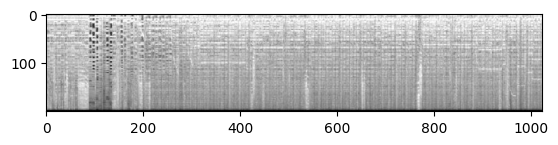

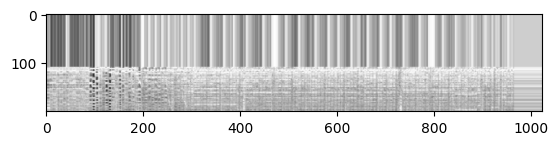

In [48]:
x,y = train_generator.next()
x2,y2 = train_generator_aug.next()

image = x[1]
ax = plt.imshow(image)
plt.show(ax)

image = x2[1]
ax = plt.imshow(image)
plt.show(ax)